# Demo notebook

In this folder, you will store your notebooks.

In [1]:
def hello_world():
    msg = """
    Hello world!
    """
    return msg

In [2]:
print(hello_world())


    Hello world!
    


## Prefect

Small tryout. The question is whether or not this holds any benefits for my purposes. Scaling is a real challenge, and at least it is encouraging that someone did some decent work here.

In [3]:
from prefect import task

@task
def say_hello(person: str) -> None:
    print("Hello, {}!".format(person))


In [4]:
@task
def add(x, y=1):
    return x + y

Now we define a flow, which is basically a script. This could be training a model etc. This is nice, but my difficulties usually arise with IO and managing all the configurations. I surely hope prefect has something to manage that, otherwise it is possibly in vain.

In [5]:
from prefect import Flow

with Flow("My first flow!") as flow_01:
    first_result = add(1, y=2)
    second_result = add(x=first_result, y=100)

In [13]:
state = flow_01.run()

[2019-08-20 09:26:02,760] INFO - prefect.FlowRunner | Beginning Flow run for 'My first flow!'
[2019-08-20 09:26:02,761] INFO - prefect.FlowRunner | Starting flow run.
[2019-08-20 09:26:02,768] INFO - prefect.TaskRunner | Task '1': Starting task run...
[2019-08-20 09:26:02,769] INFO - prefect.TaskRunner | Task '1': finished task run for task with final state: 'Success'
[2019-08-20 09:26:02,770] INFO - prefect.TaskRunner | Task '2': Starting task run...
[2019-08-20 09:26:02,771] INFO - prefect.TaskRunner | Task '2': finished task run for task with final state: 'Success'
[2019-08-20 09:26:02,772] INFO - prefect.TaskRunner | Task 'add': Starting task run...
[2019-08-20 09:26:02,774] INFO - prefect.TaskRunner | Task 'add': finished task run for task with final state: 'Success'
[2019-08-20 09:26:02,775] INFO - prefect.TaskRunner | Task '100': Starting task run...
[2019-08-20 09:26:02,777] INFO - prefect.TaskRunner | Task '100': finished task run for task with final state: 'Success'
[2019-08-

In [15]:
state.result

{<Task: 1>: <Success: "Task run succeeded.">,
 <Task: add>: <Success: "Task run succeeded.">,
 <Task: 2>: <Success: "Task run succeeded.">,
 <Task: add>: <Success: "Task run succeeded.">,
 <Task: 100>: <Success: "Task run succeeded.">}

In [16]:
first_task_state.result, second_task_state.result

(3, 103)

In [7]:
assert state.is_successful()
first_task_state = state.result[first_result]
first_task_state.result

3

In [8]:
assert first_task_state.result == 3

second_task_state = state.result[second_result]
assert second_task_state.is_successful()
assert second_task_state.result == 103

## Cluster

We have set up a tiny dask cluster and now we'll see whether we get to use it. If so, this would be a pretty big win.

In [20]:
from prefect import task, Flow
import datetime
import random
from time import sleep


@task
def inc(x):
    sleep(random.random() / 10)
    return x + 1


@task
def dec(x):
    sleep(random.random() / 10)
    return x - 1


@task
def add(x, y):
    sleep(random.random() / 10)
    return x + y


@task(name="sum")
def list_sum(arr):
    return sum(arr)


with Flow("dask-example") as flow_dask:
    incs = inc.map(x=range(100))
    decs = dec.map(x=range(100))
    adds = add.map(x=incs, y=decs)
    total = list_sum(adds)

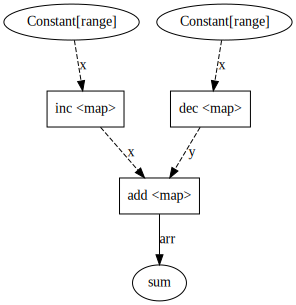

In [21]:
flow_dask.visualize()

In [18]:
from prefect.engine.executors import DaskExecutor

executor = DaskExecutor(address="tcp://134.58.41.99:8786")

In [38]:
state_dask = flow_dask.run(executor=executor)

[2019-08-20 09:29:35,418] INFO - prefect.FlowRunner | Beginning Flow run for 'dask-example'
[2019-08-20 09:29:35,420] INFO - prefect.FlowRunner | Starting flow run.
[2019-08-20 09:29:36,669] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


In [48]:
state_dask

<Success: "All reference tasks succeeded.">

In [49]:
total

<Task: sum>

In [50]:
type(total)

prefect.tasks.core.function.FunctionTask

In [47]:
# Total is actually a string that can be used to access the result of that task
state_dask.result[total].result

9900

In [54]:
sum(range(1, 101)) + sum(range(-1,99))

9900

Alright, this somehow runs on a dask cluster now and that makes me pretty happy.

In [55]:
executor.address

'tcp://134.58.41.99:8786'

# Big Task

In [60]:
from prefect import task, Flow
import datetime
import random
from time import sleep


@task
def inc(x):
    return x + 1

@task
def double(x):
    return x*2


@task
def half(x):
    return x/2


@task
def dec(x):
    return x - 1


@task
def add(x, y):
    return x + y


@task(name="sum")
def list_sum(arr):
    return sum(arr)


with Flow("dask-example") as flow_dask_02:
    our_range = range(10**3)
    incs = inc.map(x=our_range)
    decs = dec.map(x=our_range)
    
    halves = half.map(x=our_range)
    double = double.map(x=our_range)
    
    adds = add.map(x=incs, y=decs)
    adds_2 = add.map(x=adds, y=halves)
    adds_3 = add.map(x=adds_2, y=double)
    total = list_sum(adds_3)

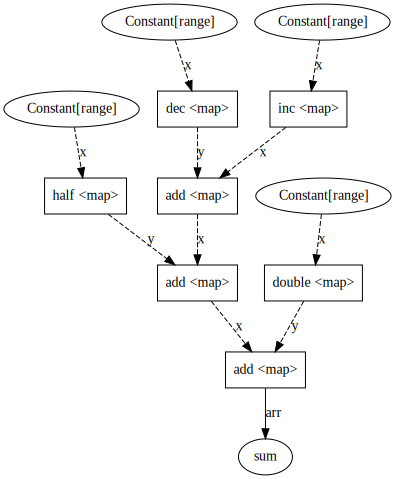

In [61]:
flow_dask_02.visualize()

In [58]:
state_big_flow = flow_dask_02.run(executor=executor)

[2019-08-20 09:32:48,263] INFO - prefect.FlowRunner | Beginning Flow run for 'dask-example'
[2019-08-20 09:32:48,265] INFO - prefect.FlowRunner | Starting flow run.
[2019-08-20 09:32:59,677] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


In [59]:
state_big_flow.result[total].result

2247750.0